# instructions:

This Jupyter Notebook can be used to search the Scielo network for desired keywords or phrases pertaining to research topics. For example, you can search for 'niobium', 'aerospace', or 'soybean biodiesel'. 

Note that if you search for a phrase with multiple words only clusters which contain all of that phrase's constituent words will show up in the results. Please do not include any punctuation in the search term. 

You can change the following parameters:
- the search term by setting the variable 'query'
- the threshold for the minimum number of times a keyword must appear in a cluster to include it in search results, 'mycount'
- the ID of the specific cluster you'd like to read through for detailed bibliographic information. Look at this after running previous cells.

Don't change any of the other code or it won't work!

After you have adjusted the parameters you want, go to the "Cell" menu at the top left and click "Run All" to see results, or run cells one at a time by clicking the "Run" button (in between the down arrow and the stop buttons). 

In [1]:
#don't change anything here
import copy
from collections import Counter
import pandas as pd
import numpy as np
import networkx as nx
import nltk
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from adjustText import adjust_text

nltk.download('punkt')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

ps = PorterStemmer()
G1 = nx.read_gpickle('network_part1.pkl')
G2 = nx.read_gpickle('network_part2.pkl')
G3 = nx.read_gpickle('network_part3.pkl')
G4 = nx.read_gpickle('network_part4.pkl')
G = nx.compose(G1, G2)
G = nx.compose(G, G3)
G = nx.compose(G, G4)

groups = {}
grouplist = []
IDlist = []
x = []
y = []

for node in G.nodes():
    if type(node) == int:
        groups.setdefault(G.node[node]['group'],[]).extend(list(set(G.node[node]['TA_words'])))
        grouplist.append(G.node[node]['group'])
        IDlist.append(G.node[node]['index'])
        x.append(G.node[node]['viz']['position']['x'])
        y.append(G.node[node]['viz']['position']['y'])
        
nodeframe = pd.DataFrame({'ID': IDlist, 'Group': grouplist, 'x': x, 'y': y})
nodeframe.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eprot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Group,ID,x,y
0,1,23549,-1724.9526,-3686.4402
1,1,22162,-1685.4515,-3683.2970
2,1,7646,-1643.9688,-3679.7146
3,1,19787,-1720.4603,-3644.8289
4,1,14260,-1613.8620,-3717.5273


### replace the text inside the quotes in the next cell to set the keyword you want to search for

In [37]:
query = 'aerospace'

query = [ps.stem(item) for item in nltk.word_tokenize(query.lower())]

query

['aerospac']

### this is the threshold for the minimum number of papers in a cluster that should contain each keyword. Set to 1 for the broadest possible search and increase if you want more specific resuls. 

In [38]:
mycount = 1

In [39]:
#don't change anything here
cluster_dict = {}
cluster_list = []
count_list = []
for i in groups:
    allthere = 1
    count = 9999
    for j in query:
        temp = groups[i].count(j)
        allthere = allthere * temp
        if temp < count:
            count = copy.deepcopy(temp)
    
    if count >= mycount and allthere > 0:
        cluster_dict[i] = {}
        cluster_dict[i]['nodes'] = []
        cluster_dict[i]['count'] = count
        count_list.append(cluster_dict[i]['count'])
        cluster_list.append(i)
        
for node in G.nodes():
    if G.node[node]['group'] in cluster_list:
        temp = copy.deepcopy(G.node[node])
        temp.pop('TA', None)
        temp.pop('TA_words', None)
        temp.pop('viz', None)
        cluster_dict[G.node[node]['group']]['nodes'].append(temp)

### the next cell shows search results for specific clusters, in a graph and a table

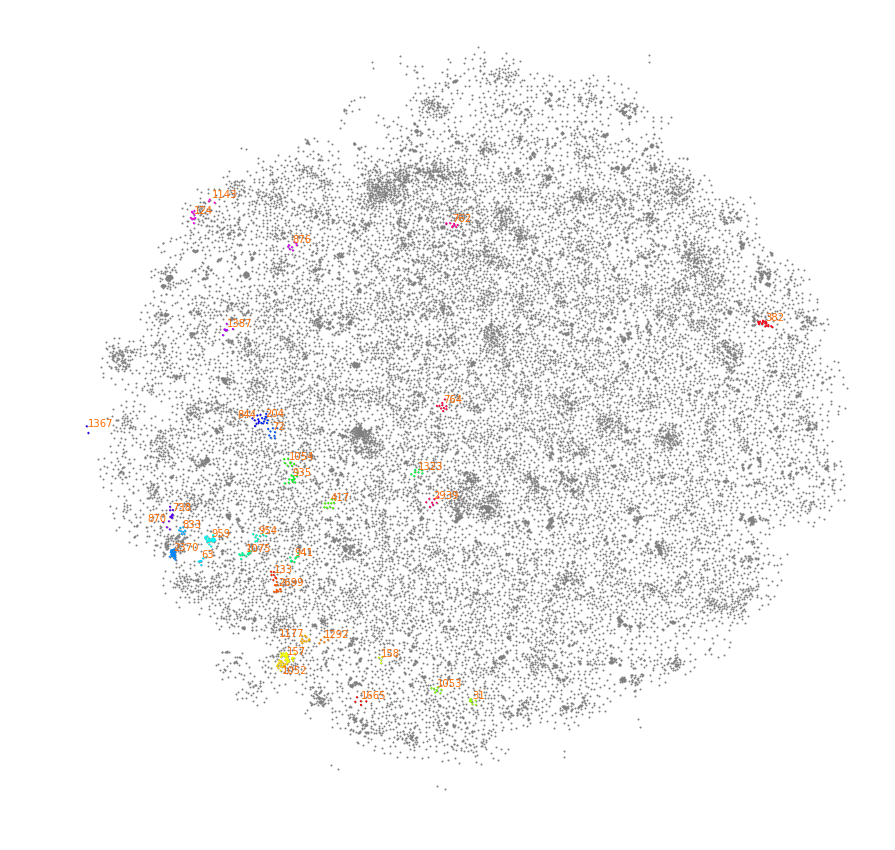

,hits,# papers,keywords
ID,,,
31,1,5,research wast final composit natur properti support organ requir chlorid
63,2,7,evolut phase composit research prepar liquid materi chemic mixtur heat
72,1,12,oxid electron graphen microscopi scan materi modifi chemic prepar ray
124,1,5,properti densiti chemic mainli dope crystallin synthes thermal mechan synthesi
133,1,11,composit materi lamin glass epoxi fiber mechan properti load commerci
157,1,17,fiber composit properti reinforc mechan materi matrix modulu strength tensil
158,2,39,fiber composit mechan properti reinforc materi polym matrix strength sem
204,1,4,simul properti exposur dynam function polym densiti phase case critic
382,1,11,numer behavior viscoelast dynam damp materi element finit load larg


In [40]:
cluster_results = pd.DataFrame({'ID': cluster_list, 'hits': count_list})
cluster_results = cluster_results.set_index('ID')
cluster_results['# papers'] = 0
cluster_results['keywords'] = ''

for i in range(1,max(groups)+1):
    if i in cluster_results.index.values:
        cluster_results.loc[i, '# papers'] = len(cluster_dict[i]['nodes'])
        cluster_results.loc[i, 'keywords'] = ' '.join(t[0] for t in Counter(groups[i]).most_common(10))

nodehits = copy.deepcopy(nodeframe)
nodehits['bool'] = nodehits['Group'].isin(list(cluster_results.index))
nodehits = nodehits[nodehits['bool'] == True]
nodehits['group_color'] = pd.factorize(nodehits['Group'])[0]
cluster_results['x'] = nodehits.groupby('Group')['x'].mean()
cluster_results['y'] = nodehits.groupby('Group')['y'].mean()

fig, ax = plt.subplots(figsize=(15,15))
ax.axis("off")
ax.scatter(np.array(nodeframe[['x' ,'y']])[:,0], np.array(nodeframe[['x' ,'y']])[:,1], c="gray", s=1)
ax.scatter(np.array(nodehits[['x', 'y']])[:,0], np.array(nodehits[['x', 'y']])[:,1], c=list(nodehits['group_color']), cmap = plt.get_cmap("hsv"), s=1)
texts = [plt.text(list(cluster_results['x'])[i], list(cluster_results['y'])[i], list(set(list(nodehits['Group'])))[i], color='#ff6a00') for i in range(len(list(cluster_results['x'])))]
adjust_text(texts)
    
cluster_results = cluster_results.drop(['x', 'y'], axis=1)
plt.show()  
cluster_results

In [6]:
#don't change anything here
authors = []
institutions = []

for i_id, i_item in cluster_dict.items():
    for j in i_item['nodes']:
        authors.extend(j['authors'])
        institutions.extend(j['affiliations'])

### this lists the most common authors from the search
syntax is ('Author Name', # hits)

In [7]:
#don't change anything here
Counter(authors).most_common(20)

[('Sergio Neves Monteiro', 7),
 ('Frederico Muylaert Margem', 4),
 ('Gilberto Fisch', 4),
 ('Jingshun Liu', 4),
 ('Rita de Cassia Lazzarini Dutra', 3),
 ('Wagner Anacleto Pinheiro', 3),
 ('Mauricio Ribeiro Baldan', 3),
 ('Emerson Sarmento Goncalves', 3),
 ('Mirabel Cerqueira Rezende', 3),
 ('Edson Cocchieri Botelho', 3),
 ('Luiz Claudio Pardini', 3),
 ('Fabio Oliveira Braga', 3),
 ('Piter Gargarella', 3),
 ('Claudio Shyinti Kiminami', 3),
 ('Jose Eduardo Spinelli', 3),
 ('Thiago Antonio Paixao de Sousa Costa', 3),
 ('Otavio Fernandes Lima da Rocha', 3),
 ('Amauri Garcia', 3),
 ('Alexandre Furtado Ferreira', 3),
 ('Alexandre Queiroz Bracarense', 3)]

### this lists the most common institutions
syntax is ('Institution', # hits)

In [8]:
#don't change anything here
Counter(institutions).most_common(10)

[('Departamento de Ciencia e Tecnologia Aeroespacial - Instituto de Aeronautica e Espaco - Divisao de Materiais - Sao Jose dos Campos/SP - Brazil.',
  6),
 ('Instituto de Aeronautica e Espaco - Sao Jose dos Campos/SP - Brazil', 3),
 ('Departamento de Ciencia e Tecnologia Aeroespacial - Instituto Tecnologico de Aeronautica - Divisao de Engenharia Mecanica - Sao Jose dos Campos/SP - Brazil.',
  3),
 ('University of Campinas, Campinas - SP - Brasil', 2),
 ('Instituto Nacional de Pesquisas Espaciais - Laboratorio Associado de Sensores - Sao Jose dos Campos/SP - Brazil.',
  2),
 ('Departamento de Ciencia e Tecnologia Aeroespacial - Instituto Tecnologico de Aeronautica - Divisao de Ciencias Fundamentais - Sao Jose dos Campos/SP - Brazil.',
  2),
 ('Universidade Federal de Sao Paulo - Instituto de Ciencia e Tecnologia - Curso de Engenharia de Materiais - Sao Jose dos Campos/SP - Brazil.',
  2),
 ('Department of Materials Science, Instituto Militar de Engenharia - IME, Praca General Tiburcio, 

### change the number in the square brackets to the cluster ID you want to examine

In [32]:
cluster_dict[297]['nodes']

[{'abstract': 'The phosphate recovery from a 20 mg L-1 Na2HPO4 solution through precipitation with Ca(OH)2 followed by electroflotation was evaluated. X-ray diffraction and particle size measurements indicated that the precipitates were a mixture of hydroxyapatite and calcium-deficient hydroxyapatite, with size ranging from 3 to 10 mm. Electroflotation with Na-oleate as surfactant was used to recover the precipitates. The surfactant adsorption was evaluated through zeta potential measurements. The influence of Na-oleate concentration, pH and bubble size on phosphate recovery was investigated. In the absence of Na-oleate, a phosphate recovery of 50% was achieved, while in the presence of 20 mg L-1 of Na-oleate it was increased to 90%, at pH 11. The phosphate recovery also increased with Ca(OH)2 concentration increase and bubble size decrease, reaching 100% at 300 mg L-1 Ca(OH)2 and bubble size around 39 um.',
  'affiliations': ['Metallurgical and Materials Engineering Program, PEMM/COPP